In [1]:
import pandas as pd
import re
import ast
import numpy as np
import torch
from tqdm import tqdm
from loguru import logger
import os
import random
import matplotlib.pyplot as plt

In [28]:
from torch_geometric.data import Data
from core.ToTorch.DataBuilder import QAMaskBuilder
import torch.nn.functional as F
from config.config import (MetaQA_CONFIG)
from core.NeuralNet.GNN import GCN,RGCN

In [3]:
KB_PATH = '.\data\MetaQA\source_data\kb.txt'
KB_ENTITIES = '.\data\MetaQA\source_data\kb_entity_dict.txt'
KB_PROPERTIES = '.\data\MetaQA\source_data\kb_properties.txt'
QA_DEV_PATH = ".\data\MetaQA\source_data\one-hop\qa_dev.txt"
QA_TEST_PATH = ".\data\MetaQA\source_data\one-hop\qa_test.txt"
QA_TRAIN_PATH = '.\data\MetaQA\source_data\one-hop\qa_train.txt'

## Get predicates

In [56]:
kb  = pd.read_csv(KB_PATH, delimiter='|', names = ['subject', 'predicate','object'])
kb.head()

,Kismet,directed_by,William Dieterle
0,Kismet,written_by,Edward Knoblock
1,Kismet,starred_actors,Marlene Dietrich
2,Kismet,starred_actors,Edward Arnold
3,Kismet,starred_actors,Ronald Colman
4,Kismet,starred_actors,James Craig


In [9]:
kb.predicate.unique()

array(['directed_by', 'written_by', 'starred_actors', 'release_year',
       'in_language', 'has_tags', 'has_genre', 'has_imdb_votes',
       'has_imdb_rating'], dtype=object)

In [14]:
kb_properties = pd.DataFrame(kb.predicate.unique(), columns=['predicate'])
kb_properties['label'] = kb_properties['predicate'].str.replace('_', ' ')
kb_properties

,predicate,label
0,directed_by,directed by
1,written_by,written by
2,starred_actors,starred actors
3,release_year,release year
4,in_language,in language
5,has_tags,has tags
6,has_genre,has genre
7,has_imdb_votes,has imdb votes
8,has_imdb_rating,has imdb rating


In [16]:
#kb_properties.to_csv(KB_PROPERTIES, index=False)

## Process QA files [1-hop, 2-hop, 3-hop] to get
[Question, concept, answers]

In [35]:
def extract_concepts(string:str):
    return re.findall(r'\[(.*?)\]',string)

### ONE-Hop

In [40]:
qa_dev = pd.read_csv(QA_DEV_PATH, delimiter='\t', names = ['question','answers'])
qa_dev['concepts'] = qa_dev['question'].apply(extract_concepts)
qa_dev['answers'] = qa_dev['answers'].str.split('|')
qa_dev['question'] = qa_dev['question'].str.replace('[','')
qa_dev['question'] = qa_dev['question'].str.replace(']','')
#qa_dev[['question', 'concepts', 'answers']].to_csv('.\data\MetaQA\source_data\one-hop\qca_dev.csv', index=False)

# qca for testing set
qa_test = pd.read_csv(QA_TEST_PATH, delimiter='\t', names = ['question','answers'])
qa_test['concepts'] = qa_test['question'].apply(extract_concepts)
qa_test['answers'] = qa_test['answers'].str.split('|')
qa_test['question'] = qa_test['question'].str.replace('[','')
qa_test['question'] = qa_test['question'].str.replace(']','')
qa_test[['question', 'concepts', 'answers']].to_csv('.\data\MetaQA\source_data\one-hop\qca_test.csv', index=False)

# qca for training set
qa_train = pd.read_csv(QA_TRAIN_PATH, delimiter='\t', names = ['question','answers'])
qa_train['concepts'] = qa_train['question'].apply(extract_concepts)
qa_train['answers'] = qa_train['answers'].str.split('|')
qa_train['question'] = qa_train['question'].str.replace('[','')
qa_train['question'] = qa_train['question'].str.replace(']','')
qa_train[['question', 'concepts', 'answers']].to_csv('.\data\MetaQA\source_data\one-hop\qca_train.csv', index=False)

### TWO Hops

In [41]:
QA_DEV_2_HOP_PATH = r".\data\MetaQA\source_data\two-hop\qa_dev.txt"
QA_TEST_2_HOP_PATH = r".\data\MetaQA\source_data\two-hop\qa_test.txt"
QA_TRAIN_2_HOP_PATH = r".\data\MetaQA\source_data\two-hop\qa_train.txt"
QA_2_HOP_BASE_PATH = r".\data\MetaQA\source_data\two-hop"

In [45]:
#DEV
qa_dev = pd.read_csv(QA_DEV_2_HOP_PATH, delimiter='\t', names = ['question','answers'])
qa_dev['concepts'] = qa_dev['question'].apply(extract_concepts)
qa_dev['answers'] = qa_dev['answers'].str.split('|')
qa_dev['question'] = qa_dev['question'].str.replace('[','')
qa_dev['question'] = qa_dev['question'].str.replace(']','')
qa_dev[['question', 'concepts', 'answers']].to_csv(os.path.join(QA_2_HOP_BASE_PATH,'qca_dev.csv'), index=False)
# qca for testing set
qa_test = pd.read_csv(QA_TEST_2_HOP_PATH, delimiter='\t', names = ['question','answers'])
qa_test['concepts'] = qa_test['question'].apply(extract_concepts)
qa_test['answers'] = qa_test['answers'].str.split('|')
qa_test['question'] = qa_test['question'].str.replace('[','')
qa_test['question'] = qa_test['question'].str.replace(']','')
qa_test[['question', 'concepts', 'answers']].to_csv(os.path.join(QA_2_HOP_BASE_PATH,'qca_test.csv'), index=False)

# qca for training set
qa_train = pd.read_csv(QA_TRAIN_2_HOP_PATH, delimiter='\t', names = ['question','answers'])
qa_train['concepts'] = qa_train['question'].apply(extract_concepts)
qa_train['answers'] = qa_train['answers'].str.split('|')
qa_train['question'] = qa_train['question'].str.replace('[','')
qa_train['question'] = qa_train['question'].str.replace(']','')
qa_train[['question', 'concepts', 'answers']].to_csv(os.path.join(QA_2_HOP_BASE_PATH,'qca_train.csv'), index=False)

## Process KB entities

In [23]:
kb_entities  = pd.read_csv(KB_ENTITIES, delimiter='\t',names = ['idx','label'])
kb_entities.head(1)

,idx,label
0,0,Kismet


In [27]:
kb_entities.iloc[:,1].to_csv('.\data\MetaQA\source_data\kb_entities.csv', sep='\t', index=False )

## Modelling

In [27]:
training_subgraphs = np.load('data\MetaQA\source_data\one-hop\dev_subgraphs.npz',allow_pickle=True)
testing_subgraphs = np.load('data\MetaQA\source_data\one-hop\dev_subgraphs.npz',allow_pickle=True)

In [4]:
qa_data_builder = QAMaskBuilder(
    triples_path=MetaQA_CONFIG['KB_PATH'],
    entities_labels_path=MetaQA_CONFIG['ENTITIES_LABELS_PATH'],
    properties_labels_path=MetaQA_CONFIG['PROPERTIES_LABELS_PATH'],
    embeddings_path=MetaQA_CONFIG['GRAPH_EMBEDDINGS_PATH'],
    training_questions_concepts_answers_file_path = MetaQA_CONFIG['QUESTIONS_CONCEPTS_ANSWERS_1_HOP_DEV_PATH'],
    testing_questions_concepts_answers_file_path = MetaQA_CONFIG['QUESTIONS_CONCEPTS_ANSWERS_1_HOP_DEV_PATH'],
    training_questions_embeddings_path = MetaQA_CONFIG['QUESTIONS_EMBEDDINGS_1_HOP_DEV_PATH'],
    testing_questions_embeddings_path = MetaQA_CONFIG['QUESTIONS_EMBEDDINGS_1_HOP_DEV_PATH'],
    is_vad_kb=False 
)

In [5]:
data = qa_data_builder.build_data()
data

Data(x=[43234, 768], edge_index=[2, 269482], edge_type=[269482])

In [18]:
training_questions_subgraphs_path = 'data\MetaQA\source_data\one-hop\dev_subgraphs.npz'

In [24]:
#load training_question embeddings
training_questions_to_subgraphs = {}
loaded_data = np.load(training_questions_subgraphs_path, allow_pickle=True)
for key in loaded_data.keys():
    training_questions_to_subgraphs[key] = loaded_data[key]

In [31]:
training_questions_to_subgraphs[key]

array({'question_subgraph_nodes': tensor([   58,    85,   106,   178,   511,  3529,  6222,  6824,  7022,  9826,
        17982, 17984, 24652, 24653, 24654, 32512, 32513, 32514, 32515, 36468,
        39804]), 'question_subgraph_concept_mask': tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False]), 'question_subgraph_answer_mask': tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
         True]), 'question_y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]), 'reindexed_question_subgraph_edge_index': tensor([[12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20,
         20, 20, 20, 20, 14, 14, 14],
        [13,  7, 14,  1, 10, 16, 14, 17,  3,  4, 18,  8,  5, 11, 19, 19,  0,  9,
          6, 14,  2,  5, 12, 15, 20]]), 'question_e

In [32]:
question = []
subgraph_node_count = []
subgraph_edge_count = []
for key in training_questions_to_subgraphs.keys():
    #training_questions_to_subgraphs[key].item()
    question.append(key)
    subgraph_node_count.append(training_questions_to_subgraphs[key].item()['question_subgraph_nodes'].size()[0])
    subgraph_edge_count.append(training_questions_to_subgraphs[key].item()['question_edge_type'].size()[0])

subgraph_stats_df = pd.DataFrame({'question':question,'subgraph_node_count':subgraph_node_count,'subgraph_edge_count':subgraph_edge_count})
subgraph_stats_df.head(2) 

,question,subgraph_node_count,subgraph_edge_count
0,what movies did Temuera Morrison act in,21,25
1,what movies did Evelyn Venable act in,28,31


In [38]:
len(subgraph_stats_df)

9989

In [37]:
subgraph_stats_df.subgraph_node_count.max()

9648

In [39]:
subgraph_stats_df.subgraph_edge_count.max()

12747

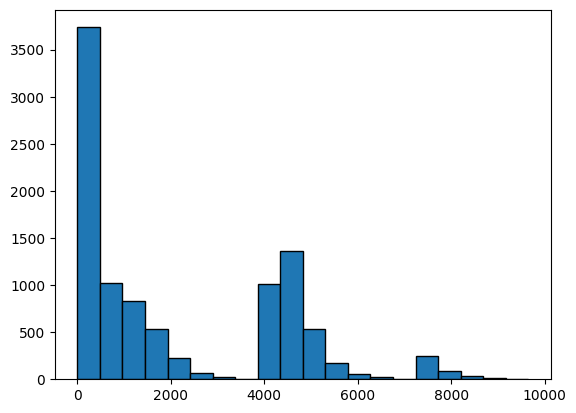

In [41]:
plt.hist(subgraph_node_count, bins=20, edgecolor='black')
plt.show()

In [42]:
subgraph_stats_df[subgraph_stats_df.subgraph_node_count>7000]

,question,subgraph_node_count,subgraph_edge_count
1450,the film West Is West starred which actors,7633,8828
1469,the movie It Runs in the Family starred who,7801,9257
1476,who acted in Such Good Friends,7631,8820
1485,who acted in the movie The Angriest Man in Bro...,7526,8713
1488,who stars in Bright Eyes,8105,9802
...,...,...,...
8609,what year was About a Boy released,7619,9555
8622,what year was the movie The Three Musketeers r...,8817,11269
8624,"the movie Madea's Big Happy Family, when was i...",7600,8871
8711,what year was SLC Punk! released,7548,8667


In [48]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


'2023-09-14 11:05:26'

In [27]:
def get_question_training_x_mask(question_subgraph_data,n=18):
    
    question_training_mask = torch.zeros_like(question_subgraph_data['question_subgraph_nodes'], dtype=torch.bool)

    question_subgraph_concept_mask = question_subgraph_data['question_subgraph_concept_mask']
    question_subgraph_answer_mask  = question_subgraph_data['question_subgraph_answer_mask']

    # Exclude question_mask and answer_mask items
    valid_indices = torch.where(~question_subgraph_concept_mask & ~question_subgraph_answer_mask)[0]

    if n < len(valid_indices):
        random_indices  = random.sample(valid_indices.tolist(), n)
        question_training_mask[random_indices] = True
        question_training_mask = question_training_mask | question_subgraph_answer_mask
    else:
        question_training_mask[~question_subgraph_concept_mask] = True
    
    return question_training_mask

In [37]:
def get_question_data(question:str, training=False):#

    if training:
        question_subgraph_data = training_subgraphs[question].item()
            
        # q_x
        q_x = torch.cat(
            (
                data.x[question_subgraph_data['question_subgraph_nodes']],
                torch.from_numpy(qa_data_builder.training_questions_to_embeddings[question].reshape(1, -1).repeat(data.x[question_subgraph_data['question_subgraph_nodes']].shape[0], axis=0)),
            ),
            dim=1,
        )  # broadcast the question emb to match the x dim

        # q_edge_index
        q_edge_index =  question_subgraph_data['reindexed_question_subgraph_edge_index']

        # q_edge_type
        q_edge_type = question_subgraph_data['question_edge_type']

        # q_training_mask
        q_training_mask = get_question_training_x_mask(question_subgraph_data,n=18)

        # q_y
        q_y = question_subgraph_data['question_y']

        return Data(x=q_x, edge_index=q_edge_index, edge_type=q_edge_type, train_mask=q_training_mask, y=q_y)
    
    else:#testing phase

        #load question specific subgraph
        question_subgraph_data = testing_subgraphs[question].item() 
        
        #q_x
        q_x = torch.cat(
            (
                data.x[question_subgraph_data['question_subgraph_nodes']],
                torch.from_numpy(qa_data_builder.testing_questions_to_embeddings[question].reshape(1, -1).repeat(qa_data_builder.x[question_subgraph_data['question_subgraph_nodes']].shape[0], axis=0)),
            ),
            dim=1,
        )

        # q_edge_index
        q_edge_index =  question_subgraph_data['reindexed_question_subgraph_edge_index']

        # q_edge_type
        q_edge_type = question_subgraph_data['question_edge_type'] 

        return Data(x=q_x, edge_index=q_edge_index, edge_type=q_edge_type), question_subgraph_data['question_subgraph_nodes'], question_subgraph_data['question_subgraph_nodes'][question_subgraph_data['question_subgraph_answer_mask']]

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print("device type: ", device)
model = GCN(
    num_node_features=data.num_node_features*2, dim_hidden_layer=16,num_layers=1, num_classes=2
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

In [53]:
# TRAINING
model.train()
num_train_samples = qa_data_builder.training_questions_concepts_answers.shape[0]
for epoch in range(1):
    shuffled_train_indices = np.random.permutation(qa_data_builder.training_questions_concepts_answers.index.tolist())
    total_epoch_loss = 0.0
    for idx in tqdm(shuffled_train_indices):
        row = qa_data_builder.training_questions_concepts_answers.loc[idx]
        q_data = get_question_data(question=row["question"], training=True)
        q_data = q_data.to(device)
        optimizer.zero_grad()
        out,embedding = model(q_data)
        loss = F.nll_loss(out[q_data.train_mask], q_data.y[q_data.train_mask],weight = torch.tensor([1.0,20.0]).to(device))
        loss.backward()
        optimizer.step()
        total_epoch_loss +=loss.item()
    logger.debug(f"Epoch: {epoch:03d}, Loss: {(total_epoch_loss/num_train_samples):.4f}")


  0%|          | 0/9992 [00:00<?, ?it/s]

100%|██████████| 9992/9992 [07:16<00:00, 22.91it/s]
2023-09-11 16:36:49.160 | DEBUG    | __main__:<module>:17 - Epoch: 000, Loss: 0.3782


In [38]:
# EVALUATION
model.eval()
with torch.no_grad():
    res = []
    for idx, row in tqdm(qa_data_builder.testing_questions_concepts_answers.iterrows()):

        q_data, question_subgraph_nodes,question_subgraph_answer = get_question_data(question=row["question"], training=False)
        q_data = q_data.to(device)
        question_subgraph_nodes = question_subgraph_nodes.to(device)
        question_subgraph_answer = question_subgraph_answer.to(device).tolist()
        #predict
        out,_ = model(q_data)

        predicted_local_answer_nodes = torch.where(out.argmax(dim=1))[0] # local subgraph answer
        predicted_answer_nodes = question_subgraph_nodes[predicted_local_answer_nodes] # remapping local answer to global node number
        predicted_answer_node_probabilities = out.max(dim=1)[0][predicted_local_answer_nodes]
        sorted_probability_indices = torch.argsort(predicted_answer_node_probabilities, descending= True)
        count_predicted_nodes =len(predicted_answer_nodes)

        if count_predicted_nodes > 0 and count_predicted_nodes < 50:
            #logger.debug(f"answers predicted")
            is_predicted_in_actual_answers = bool(set(question_subgraph_answer) & set(predicted_answer_nodes[sorted_probability_indices].tolist()))
            res.append((row["question"], question_subgraph_answer, predicted_answer_nodes[sorted_probability_indices].tolist(),predicted_answer_node_probabilities[sorted_probability_indices].tolist(),count_predicted_nodes,is_predicted_in_actual_answers))
        
        elif count_predicted_nodes >= 50:
            res.append((row["question"], question_subgraph_answer, np.nan,np.nan,count_predicted_nodes,False))
        else:
            #logger.debug(f"NO answers found")
            res.append((row["question"], question_subgraph_answer, np.nan,np.nan,0,False))
        
        #break;
eval_res = pd.DataFrame.from_records(res,columns=["question","actual_answer_nodes","predicted_answer_nodes","probabilities_of_answer_nodes","count_predicted_nodes","is_predicted_in_actual"])
#eval_res.to_csv(os.path.join(self.experiment_results_folder_path,"evaluation_results.csv"),index=False)
logger.info("Evaluation results saved.")


9992it [03:54, 42.67it/s] 
2023-09-11 12:53:08.225 | INFO     | __main__:<module>:34 - Evaluation results saved.


## Evaluation

In [2]:
def hits_at_1(predictions, ground_truths):
    hits = 0
    no_hits_question_idx = []
    i=0
    for pred, truths in zip(predictions, ground_truths):
        if any(p == t for p in pred for t in truths):
            hits += 1
        else:
            no_hits_question_idx.append(i)
        i+=1
    return hits / len(predictions), no_hits_question_idx

def f1_score(predictions, ground_truths):
    f1_scores = []
    for pred, truths in zip(predictions, ground_truths):
        if len(pred)==0:
            precision = 0.0
            recall = 0.0
        else:
            precision = len(set(pred) & set(truths)) / len(pred)
            recall = len(set(pred) & set(truths)) / len(truths)
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)

    return sum(f1_scores) / len(predictions)

def hits_at_k(predictions, ground_truths, k):
    hits = 0
    for pred, truths in zip(predictions, ground_truths):
        if any(p in truths for p in pred[:k]):
            hits += 1
    return hits / len(predictions)

def f1_score_at_k(predictions, ground_truths):
    f1_scores = []
    for pred, truths in zip(predictions, ground_truths):
        if len(pred)==0:
            precision = 0.0
            recall = 0.0
        else:
            precision = len(set(pred) & set(truths)) / len(pred)
            recall = len(set(pred) & set(truths)) / len(truths)
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)



In [3]:
evaluation_results = pd.read_csv('./core/experiments/qa/results/20230912184556/evaluation_results.csv')
# reads columns as lists instead of strings
list_columns = ['actual_answer_nodes','predicted_answer_nodes', 'probabilities_of_answer_nodes']
for col in list_columns:
    evaluation_results[col] = evaluation_results[col].apply(lambda x : ast.literal_eval(x) if type(x)==str else [])
evaluation_results.tail(2)

evaluation_results_ = pd.read_csv('./core/experiments/qa/results/20230911231834/evaluation_results.csv')
# reads columns as lists instead of strings
list_columns = ['actual_answer_nodes','predicted_answer_nodes', 'probabilities_of_answer_nodes']
for col in list_columns:
    evaluation_results_[col] = evaluation_results_[col].apply(lambda x : ast.literal_eval(x) if type(x)==str else [])
evaluation_results_.tail(2)

,question,actual_answer_nodes,predicted_answer_nodes,probabilities_of_answer_nodes,count_predicted_nodes,is_predicted_in_actual
9990,what movies was Mark Bowden the writer of,"[19017, 29737]","[29737, 19017]","[-0.008132321760058403, -0.008132321760058403]",2,True
9991,what movies was Ryan Rowe the writer of,[17615],[17615],[-0.008129247464239597],1,True


In [4]:
# Number of questions with predicted answers count more than 50
print(len(evaluation_results[evaluation_results['count_predicted_nodes']>50]))
print(len(evaluation_results_[evaluation_results_['count_predicted_nodes']>50]))

3003
2779


In [5]:
# How many questions it could not predict
len(evaluation_results[evaluation_results['count_predicted_nodes']==0])

0

In [28]:
len(evaluation_results_[evaluation_results_['is_predicted_in_actual']==False])

32

In [14]:
df = evaluation_results[evaluation_results['count_predicted_nodes']>50]['count_predicted_nodes'].value_counts().reset_index(name='counts').sort_values(by='count_predicted_nodes', ascending=True)
df.dtypes

count_predicted_nodes    int64
counts                   int64
dtype: object

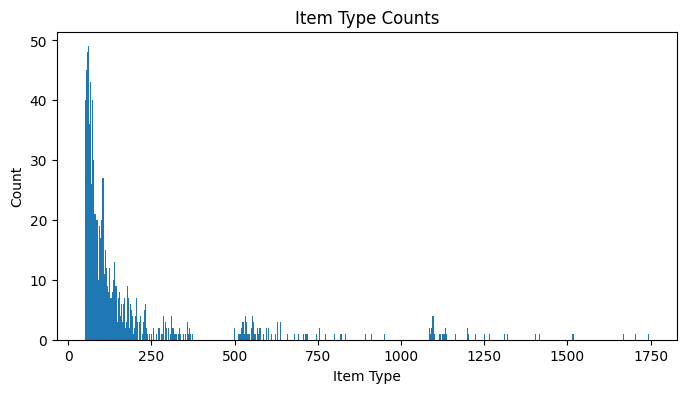

In [15]:
plt.figure(figsize=(8, 4))
plt.bar(df.count_predicted_nodes, df.counts)
plt.xlabel('Item Type')
plt.ylabel('Count')
plt.title('Item Type Counts')
plt.show()

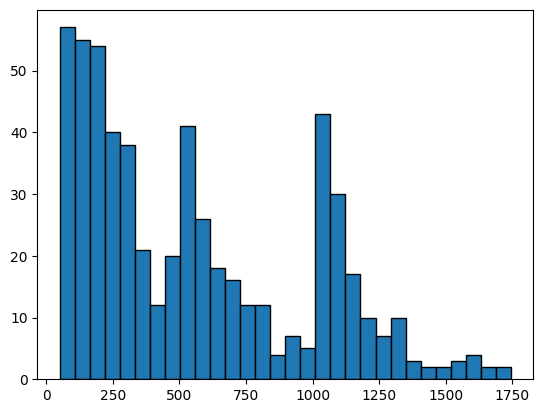

In [16]:
plt.hist(df.count_predicted_nodes, bins=30, edgecolor='black')
plt.show()

In [46]:
pred_nodes = [22329,22326, 39299, 37371]
truths = [39299, 22326, 37371]
if any(node in pred_nodes[:1] for node in truths):
#if any(p == t for p in pred_nodes for t in truths):
    print(1)

In [13]:
hits_10 =hits_at_k(evaluation_results['predicted_answer_nodes'], evaluation_results['actual_answer_nodes'],1)
print('hits@10:', np.round(hits_10,3))

hits@10: 0.186


In [55]:
wrong_q_idx[2]

764

In [56]:
evaluation_results.iloc[764]

q_idx                                                                          764
actual_answer_nodes              [598, 15933, 36591, 40615, 40339, 38432, 15061...
predicted_answer_nodes                                                          []
probabilities_of_answer_nodes                                                   []
count_predicted_nodes                                                           85
is_predicted_in_actual                                                       False
Name: 764, dtype: object

In [47]:
len(wrong_q_idx)

2900

In [33]:
f1_score(evaluation_results['predicted_answer_nodes'], evaluation_results['actual_answer_nodes'])

0.35015427991300463

In [36]:
hits_at_k(evaluation_results['predicted_answer_nodes'], evaluation_results['actual_answer_nodes'], 1)

0.3968030561978486

In [4]:
metaQA_results = pd.read_csv('./core/experiments/qa/MetaQA_experiments_masterdata.csv')
metaQA_results[['time_stamp', 'Epochs', 'Learning Rate', 'hidden_dimension',
       'num_layers', 'Model', 'hits@1', 'F1', 'hits@3', 'hits@5',
       'mrr']]

,time_stamp,Epochs,Learning Rate,hidden_dimension,num_layers,Model,hits@1,F1,hits@3,hits@5,mrr
0,2023:09:11 17:15:29,1,0.001,16,2,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.326761,0.289240,0.633307,0.795536,0.433461
1,2023:09:11 17:20:13,1,0.001,16,2,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.346677,0.394850,0.625200,0.782526,0.433752
2,2023:09:11 17:20:46,1,0.001,16,2,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.343275,0.380921,0.620296,0.781425,0.431000
3,2023:09:11 17:39:59,1,0.001,16,2,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.354077,0.404633,0.618981,0.780135,0.434528
4,2023:09:11 20:50:08,5,0.001,16,2,RGCN(\n (layers): ModuleList(\n (0): RGCNC...,0.408968,0.348015,0.561074,0.641098,0.441581
5,2023:09:12 03:21:21,10,0.001,16,2,RGAT(\n (layers): ModuleList(\n (0): RGATC...,0.394491,0.345914,0.566402,0.649844,0.422419
6,2023:09:12 05:24:27,10,0.001,16,2,RGCN(\n (layers): ModuleList(\n (0): RGCNC...,0.420730,0.356768,0.598975,0.680004,0.465545


In [5]:
metaQA_results

,time_stamp,info,Epochs,Learning Rate,hidden_dimension,num_layers,num_bases,Model,hits@1,F1,...,recall@1,recall@3,recall@5,model_directory,triples_path,entities_labels_path,properties_labels_path,graph_embeddings_path,training_questions_concepts_answers_file_path,testing_questions_concepts_answers_file_path
0,2023:09:11 17:15:29,Task: MetaQA with GNN,1,0.001,16,2,NaN,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.326761,0.289240,...,0.172032,0.452447,0.631119,./core/experiments/qa/results/20230911171132,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_dev.csv,data/MetaQA/source_data/one-hop/qca_dev.csv
1,2023:09:11 17:20:13,Task: MetaQA with GNN,1,0.001,16,2,NaN,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.346677,0.394850,...,0.182518,0.471416,0.658412,./core/experiments/qa/results/20230911171557,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_dev.csv,data/MetaQA/source_data/one-hop/qca_dev.csv
2,2023:09:11 17:20:46,Task: MetaQA with GNN,1,0.001,16,2,NaN,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.343275,0.380921,...,0.180726,0.469888,0.658148,./core/experiments/qa/results/20230911170816,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_dev.csv,data/MetaQA/source_data/one-hop/qca_dev.csv
3,2023:09:11 17:39:59,Task: MetaQA with GNN,1,0.001,16,2,NaN,GCN(\n (layers): ModuleList(\n (0): GCNCon...,0.354077,0.404633,...,0.182100,0.464661,0.651879,./core/experiments/qa/results/20230911172209,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_train.csv,data/MetaQA/source_data/one-hop/qca_test.csv
4,2023:09:11 20:50:08,Task: one hop MetaQA with GNN,5,0.001,16,2,NaN,RGCN(\n (layers): ModuleList(\n (0): RGCNC...,0.408968,0.348015,...,0.210330,0.398532,0.519570,./core/experiments/qa/results/20230911173711,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_train.csv,data/MetaQA/source_data/one-hop/qca_test.csv
5,2023:09:12 03:21:21,Task: one hop MetaQA with GNN,10,0.001,16,2,NaN,RGAT(\n (layers): ModuleList(\n (0): RGATC...,0.394491,0.345914,...,0.202885,0.403650,0.522258,./core/experiments/qa/results/20230911231834,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_train.csv,data/MetaQA/source_data/one-hop/qca_test.csv
6,2023:09:12 05:24:27,Task: one hop MetaQA with GNN,10,0.001,16,2,NaN,RGCN(\n (layers): ModuleList(\n (0): RGCNC...,0.420730,0.356768,...,0.216380,0.415025,0.538648,./core/experiments/qa/results/20230911222150,./data/MetaQA/source_data/kb.txt,./data/MetaQA/source_data/kb_entities.csv,./data/MetaQA/source_data/kb_properties.txt,./data/MetaQA/graph_embeddings,data/MetaQA/source_data/one-hop/qca_train.csv,data/MetaQA/source_data/one-hop/qca_test.csv
